In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Imputer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_curve, auc

In [30]:
crash = pd.read_csv('Data/CGR_Crash_Data.csv')
crash.head(4)

,X,Y,OBJECTID,ROADSOFTID,BIKE,CITY,CRASHDATE,CRASHSEVER,CRASHTYPE,WORKZNEACT,...,VEH3DIR,VEH3TYPE,VEH3USE,WEATHER,WHEREONRD,YEAR,RDCITYTWP,RDNUMLANES,RDWIDTH,FRAMEWORK
0,-85.639647,42.927216,6001,929923,No,Grand Rapids,2007-02-16,Property Damage Only,Side-Swipe Same,Uncoded & Errors,...,U,Uncoded & Errors,Uncoded & Errors,Cloudy,On the Road,2007,Grand Rapids,2,42.0,17
1,-85.639487,42.927213,6002,935745,No,Grand Rapids,2007-06-22,Property Damage Only,Side-Swipe Same,Uncoded & Errors,...,U,Uncoded & Errors,Uncoded & Errors,Clear,On the Road,2007,Grand Rapids,2,42.0,17
2,-85.639387,42.927212,6003,926813,No,Grand Rapids,2007-01-08,Property Damage Only,Head-on,Work on Shoulder / Median,...,U,Uncoded & Errors,Uncoded & Errors,Snow,On the Road,2007,Grand Rapids,2,42.0,17
3,-85.639288,42.927210,6004,943813,No,Grand Rapids,2007-11-12,Property Damage Only,Side-Swipe Same,Uncoded & Errors,...,U,Uncoded & Errors,Uncoded & Errors,Cloudy,On the Road,2007,Grand Rapids,2,42.0,17


In [31]:
initial_shape = crash.shape
print(initial_shape)

(72977, 77)


In [32]:
crash['HITANDRUN'].value_counts()

No     57308
Yes    15669
Name: HITANDRUN, dtype: int64

## Columns Dropped
* Unfortunately, I do not know what the "OBJECTID" or "ROADSOFTID" columns mean, so I will drop them.
* Since all crashes occur in Grand Rapids, I will drop the "CITY" column.
* Since we have other features that may represent the time/date better than "CRASHDATE" we'll drop it.
* "WORKZNEACT", "WORKZNECLO", "WORKZNETYP", "ANIMAL" are primarily errors
* "DAYOFMONTH", "DAYOFWEEK" were fairly evenly distributed and did not seem to have any correlation with "HITANDRUN"
* Wanted to use "D1COND", "D2COND", "D3COND", but not enough data recorded.
* "FLEEINGSIT" looks like it could be helpful, but not sure what it means, and far too few instances
* all read no for "NONTRAFFIC"
* Such low amounts of data on Vehichle defect, dropped "V1DEFECT", "V2DEFECT"
* Such low amounts of data on any third vehicle, drop 'D3DRINKIN', 'DRIVER3AGE', 'DRIVER3SEX', 'V3DEFECT', 'V3DAMAGE', 'VEH3DIR', 'VEH3TYPE', 'VEH3USE'


* Drop all V3's

In [33]:
labels = ["OBJECTID", "ROADSOFTID", "CITY", "CRASHDATE", "WORKZNEACT", "WORKZNECLO", "WORKZNETYP",
         "DAYOFMONTH", "DAYOFWEEK", "ANIMAL", "D2COND", "D3COND", "FARMEQUIP", "FLEEINGSIT", "NONTRAFFIC", 
         "NUMOFKILL", "ORV", "PUBLICPROP", "PEDESTRIAN", "SNOWMOBILE", "SCHOOLBUS", "TRAIN", "V1DEFECT", "V2DEFECT", 
          'D3DRINKIN', 'DRIVER3AGE', 'DRIVER3SEX', 'V3DEFECT', 'V3DAMAGE', 'VEH3DIR', 'VEH3TYPE', 'VEH3USE',
          'D2DRINKIN', 'DRIVER2AGE', 'DRIVER2SEX', 
          'V2DEFECT', 'V2DAMAGE', 'VEH2DIR', 'VEH2TYPE', 'VEH2USE',
          'FRAMEWORK', 'RDCITYTWP', 'YEAR'
         ]
crash = crash.drop(labels=labels, axis=1)

In [34]:
crash['D1COND'] = crash['D1COND'].replace(to_replace = ['Other', 'Uncoded & Errors'], value = 'Unknown')
crash['D1COND'] = crash['D1COND'].replace(to_replace = ['Fatigue / Asleep', 'Sick', 'Medication', 'Emotional', 'Physically Disabled'], value = 'Fatigue / Sick')
crash['D1COND'].value_counts()

Appeared Normal    56412
Unknown            15890
Fatigue / Sick       675
Name: D1COND, dtype: int64

In [35]:
crash.groupby(["D1COND", 'HITANDRUN'])['NUMOFVEHIC'].count()

D1COND           HITANDRUN
Appeared Normal  No           50969
                 Yes           5443
Fatigue / Sick   No             607
                 Yes             68
Unknown          No            5732
                 Yes          10158
Name: NUMOFVEHIC, dtype: int64

In [36]:
crash.shape

(72977, 35)

In [37]:
crash['HITANDRUN'].value_counts()

No     57308
Yes    15669
Name: HITANDRUN, dtype: int64

In [38]:
'''# drop all rows with missing age for driver 1
missing_age1 = crash.DRIVER1AGE[crash.DRIVER1AGE > 100]
crash = crash.drop(missing_age1.index, axis=0)'''

'# drop all rows with missing age for driver 1\nmissing_age1 = crash.DRIVER1AGE[crash.DRIVER1AGE > 100]\ncrash = crash.drop(missing_age1.index, axis=0)'

In [44]:
# possibly fit regressor to predict age?
imputer = Imputer(missing_values=999, strategy='median', axis=0)
crash['DRIVER1AGE'] = imputer.fit_transform(crash.DRIVER1AGE.values.reshape(-1,1))

In [45]:
crash.shape

(72977, 35)

In [46]:
crash['D1DRINKIN'].value_counts()

No     70260
Yes     2717
Name: D1DRINKIN, dtype: int64

In [47]:
crash['HITANDRUN'].value_counts()

No     57308
Yes    15669
Name: HITANDRUN, dtype: int64

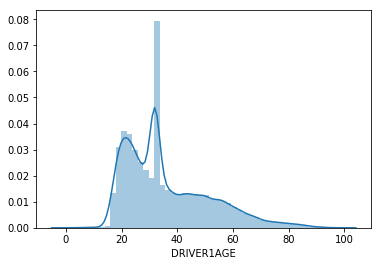

In [48]:
sns.distplot(crash['DRIVER1AGE'])

In [49]:
crash['DRIVER1SEX'].value_counts()

M    35513
F    30075
U     7389
Name: DRIVER1SEX, dtype: int64

In [50]:
# Realized that... it is very important NOT to drop the unknowns. Think about it... if it is a hit and run,
# we probably wouldn't know the sex of the driver, right? Leave this as its own category.

'''# drop all rows with missing sex for driver 1
missing_sex1 = crash.DRIVER1SEX[crash.DRIVER1SEX == "U"]
crash = crash.drop(missing_sex1.index, axis=0)'''

'# drop all rows with missing sex for driver 1\nmissing_sex1 = crash.DRIVER1SEX[crash.DRIVER1SEX == "U"]\ncrash = crash.drop(missing_sex1.index, axis=0)'

In [51]:
crash.groupby(['DRIVER1SEX', 'HITANDRUN'])['NUMOFVEHIC'].count()

DRIVER1SEX  HITANDRUN
F           No           26284
            Yes           3791
M           No           30201
            Yes           5312
U           No             823
            Yes           6566
Name: NUMOFVEHIC, dtype: int64

In [52]:
crash.shape

(72977, 35)

In [53]:
crash['D1DRINKIN'].value_counts()

No     70260
Yes     2717
Name: D1DRINKIN, dtype: int64

In [54]:
crash['HITANDRUN'].value_counts()

No     57308
Yes    15669
Name: HITANDRUN, dtype: int64

In [55]:
crash.columns

Index(['X', 'Y', 'BIKE', 'CRASHSEVER', 'CRASHTYPE', 'D1COND', 'D1DRINKIN',
       'DRIVER1AGE', 'DRIVER1SEX', 'EMRGVEH', 'GRTINJSEVE', 'HITANDRUN',
       'HOUR', 'MONTH', 'MOTORCYCLE', 'NOATYPEINJ', 'NOBTYPEINJ', 'NOCTYPEINJ',
       'NUMOFINJ', 'NUMOFOCCUP', 'NUMOFUNINJ', 'NUMOFVEHIC', 'SPDLMTPOST',
       'SPEEDLIMIT', 'SURFCOND', 'TRAFCTLDEV', 'TRUCKBUS', 'V1DAMAGE',
       'VEH1DIR', 'VEH1TYPE', 'VEH1USE', 'WEATHER', 'WHEREONRD', 'RDNUMLANES',
       'RDWIDTH'],
      dtype='object')

In [446]:
crash['BIKE'].value_counts()

No     72051
Yes      926
Name: BIKE, dtype: int64

In [447]:
crash.groupby(['DRIVER1SEX', 'HITANDRUN'])['NUMOFVEHIC'].count()

DRIVER1SEX  HITANDRUN
F           No           26284
            Yes           3791
M           No           30201
            Yes           5312
U           No             823
            Yes           6566
Name: NUMOFVEHIC, dtype: int64

In [448]:
crash.groupby(['CRASHSEVER', 'D1DRINKIN'])['NUMOFVEHIC'].count()
# Fatal injuries significantly more likely to be caused by alcohol

CRASHSEVER            D1DRINKIN
Fatal                 No              56
                      Yes             39
Injury                No           12571
                      Yes            858
Property Damage Only  No           57633
                      Yes           1820
Name: NUMOFVEHIC, dtype: int64

In [449]:
crash.groupby(['DRIVER1SEX', 'D1DRINKIN'])['NUMOFVEHIC'].count()
# Male car crashes are nearly twice as likely to have alcohol involed as female crashes

DRIVER1SEX  D1DRINKIN
F           No           29332
            Yes            743
M           No           33544
            Yes           1969
U           No            7384
            Yes              5
Name: NUMOFVEHIC, dtype: int64

In [450]:
crash.groupby(['EMRGVEH', 'D1DRINKIN'])['NUMOFVEHIC'].count()
# Emergency vehicle twice as likely with alcohol

EMRGVEH  D1DRINKIN
No       No           69785
         Yes           2672
Yes      No             475
         Yes             45
Name: NUMOFVEHIC, dtype: int64

In [451]:
crash.groupby(['HITANDRUN', 'D1DRINKIN'])['NUMOFVEHIC'].count()
# Hit and runs almost 3x more likely while drinking

HITANDRUN  D1DRINKIN
No         No           55356
           Yes           1952
Yes        No           14904
           Yes            765
Name: NUMOFVEHIC, dtype: int64

In [452]:
crash.groupby(['MOTORCYCLE', 'D1DRINKIN'])['NUMOFVEHIC'].count()

MOTORCYCLE  D1DRINKIN
No          No           69630
            Yes           2650
Yes         No             630
            Yes             67
Name: NUMOFVEHIC, dtype: int64

In [453]:
crash.groupby(['NUMOFINJ', 'D1DRINKIN'])['NUMOFVEHIC'].count()

NUMOFINJ  D1DRINKIN
0         No           57678
          Yes           1848
1         No           10030
          Yes            692
2         No            1948
          Yes            120
3         No             448
          Yes             40
4         No             107
          Yes             14
5         No              34
          Yes              2
6         No               8
7         No               3
          Yes              1
8         No               1
10        No               3
Name: NUMOFVEHIC, dtype: int64

In [56]:
bins = [0, 25, 45, 65, 100]
labels = ['speed<25', '25<speed<45', '45<speed<65', '65<speed']
crash['SPEEDLIMIT_BINS'] = pd.cut(crash['SPEEDLIMIT'], bins=bins, labels=labels)

crash.groupby(['SPEEDLIMIT_BINS', 'HITANDRUN'])['NUMOFVEHIC'].count()


SPEEDLIMIT_BINS  HITANDRUN
speed<25         No           20323
                 Yes           9804
25<speed<45      No           22480
                 Yes           4000
45<speed<65      No            6553
                 Yes            776
65<speed         No            7942
                 Yes           1083
Name: NUMOFVEHIC, dtype: int64

In [57]:
crash['SPEEDLIMIT_BINS'].value_counts()

speed<25       30127
25<speed<45    26480
65<speed        9025
45<speed<65     7329
Name: SPEEDLIMIT_BINS, dtype: int64

---

In [116]:
X = crash[['X', 'Y', 'CRASHSEVER', 'DRIVER1AGE',
       'DRIVER1SEX', 'EMRGVEH', 'HITANDRUN', 'HOUR',
          'MOTORCYCLE', 'NUMOFINJ', 'D1DRINKIN', 'D1COND']]
#y = crash['D1DRINKIN']

In [117]:
X.shape

(72977, 12)

In [118]:
X.head()

,X,Y,CRASHSEVER,DRIVER1AGE,DRIVER1SEX,EMRGVEH,HITANDRUN,HOUR,MOTORCYCLE,NUMOFINJ,D1DRINKIN,D1COND
0,-85.639647,42.927216,Property Damage Only,62.0,F,No,Yes,13,No,0,No,Appeared Normal
1,-85.639487,42.927213,Property Damage Only,31.0,M,No,Yes,18,No,0,No,Unknown
2,-85.639387,42.927212,Property Damage Only,22.0,F,No,No,8,No,0,No,Appeared Normal
3,-85.639288,42.927210,Property Damage Only,30.0,M,No,Yes,16,No,0,No,Appeared Normal
4,-85.639288,42.927210,Property Damage Only,44.0,M,No,No,15,No,0,No,Appeared Normal


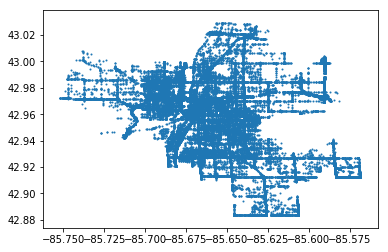

In [119]:
plt.scatter(X.X, X.Y, s=1)

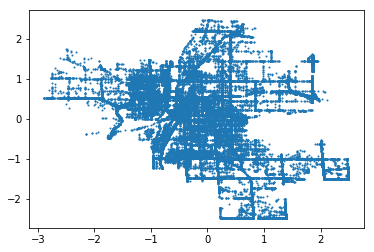

In [120]:
# Scaling the coords does not compromise the map
scaler = StandardScaler()
x_try = scaler.fit_transform(X.X.values.reshape(-1,1))
y_try = scaler.fit_transform(X.Y.values.reshape(-1,1))

plt.scatter(x_try, y_try, s=1)

In [121]:
X.to_csv('Data/Analysis2/Crash_X2.csv', index=False)


---

## Scaling and Encoding the Variables

#### Scaling

In [122]:
sc_X = StandardScaler()
X_scaled = sc_X.fit_transform(X[['X', 'Y', 'DRIVER1AGE', 'NUMOFINJ']])

In [123]:
X_scaled.shape

(72977, 4)

In [124]:
X_scaled_df = pd.DataFrame(X_scaled, columns = ['X', 'Y', 'DRIVER1AGE', 'NUMOFINJ'])

In [125]:
X_scaled_df.shape

(72977, 4)

In [126]:
X_ = X.drop(['X', 'Y', 'DRIVER1AGE', 'NUMOFINJ'], axis=1)

In [127]:
X_.shape

(72977, 8)

In [128]:
X = pd.concat([X_scaled_df, X_], axis=1)

In [129]:
X = X.dropna()

In [130]:
X['HITANDRUN'].value_counts()

No     57308
Yes    15669
Name: HITANDRUN, dtype: int64

In [131]:
X.shape

(72977, 12)

In [132]:
X['HOUR_X']=np.sin(2. * np.pi * X.HOUR / 24.)
X['HOUR_Y']=np.cos(2. * np.pi * X.HOUR / 24.)

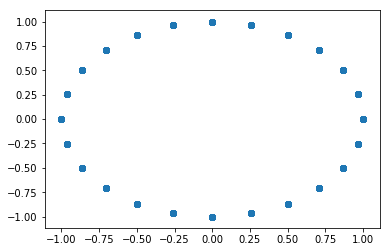

In [133]:
# Hence, the time of day is now cyclic (just as in reality)
plt.scatter(X.HOUR_X, X.HOUR_Y)

In [134]:
# Now that we have our two 'HOUR_X' and 'HOUR_Y' coords, we drop the original "HOUR" feature
X = X.drop(['HOUR'], axis=1)

In [135]:
X.columns

Index(['X', 'Y', 'DRIVER1AGE', 'NUMOFINJ', 'CRASHSEVER', 'DRIVER1SEX',
       'EMRGVEH', 'HITANDRUN', 'MOTORCYCLE', 'D1DRINKIN', 'D1COND', 'HOUR_X',
       'HOUR_Y'],
      dtype='object')

#### Encoding

In [136]:
y = X['HITANDRUN']

In [137]:
X = X.drop(['HITANDRUN'], axis=1)

In [138]:
lbl = LabelEncoder()
y = lbl.fit_transform(y)
y

array([1, 1, 0, ..., 0, 0, 0])

In [140]:
dummies = pd.get_dummies(X[['CRASHSEVER', 'DRIVER1SEX',
                            'EMRGVEH', 'D1DRINKIN',
                            'MOTORCYCLE', 'D1COND']])

In [141]:
dummies.head()

,CRASHSEVER_Fatal,CRASHSEVER_Injury,CRASHSEVER_Property Damage Only,DRIVER1SEX_F,DRIVER1SEX_M,DRIVER1SEX_U,EMRGVEH_No,EMRGVEH_Yes,D1DRINKIN_No,D1DRINKIN_Yes,MOTORCYCLE_No,MOTORCYCLE_Yes,D1COND_Appeared Normal,D1COND_Fatigue / Sick,D1COND_Unknown
0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,0
1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1
2,0,0,1,1,0,0,1,0,1,0,1,0,1,0,0
3,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0
4,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0


In [142]:
# Drop the column with target variable (HITANDRUN) and the columns for which we created dummy variables
X_ = X.drop(['CRASHSEVER', 'DRIVER1SEX', 'D1DRINKIN',
                            'EMRGVEH', 'D1COND', 
                            'MOTORCYCLE'], axis=1)
# Define the feature set X.
X = pd.concat([X_, dummies], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72977 entries, 0 to 72976
Data columns (total 21 columns):
X                                  72977 non-null float64
Y                                  72977 non-null float64
DRIVER1AGE                         72977 non-null float64
NUMOFINJ                           72977 non-null float64
HOUR_X                             72977 non-null float64
HOUR_Y                             72977 non-null float64
CRASHSEVER_Fatal                   72977 non-null uint8
CRASHSEVER_Injury                  72977 non-null uint8
CRASHSEVER_Property Damage Only    72977 non-null uint8
DRIVER1SEX_F                       72977 non-null uint8
DRIVER1SEX_M                       72977 non-null uint8
DRIVER1SEX_U                       72977 non-null uint8
EMRGVEH_No                         72977 non-null uint8
EMRGVEH_Yes                        72977 non-null uint8
D1DRINKIN_No                       72977 non-null uint8
D1DRINKIN_Yes                      7297

In [143]:
X.to_csv('Data/Analysis2/Crash_X2_prepared.csv', index=False)
pd.DataFrame(y).to_csv('Data/Analysis2/Crash_y2.csv', index=False)